## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets
import seaborn as sns

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [2]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [3]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [4]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [31]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

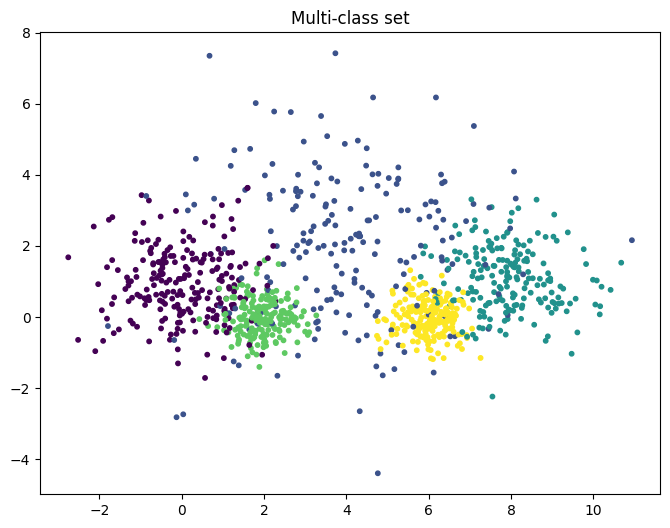

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

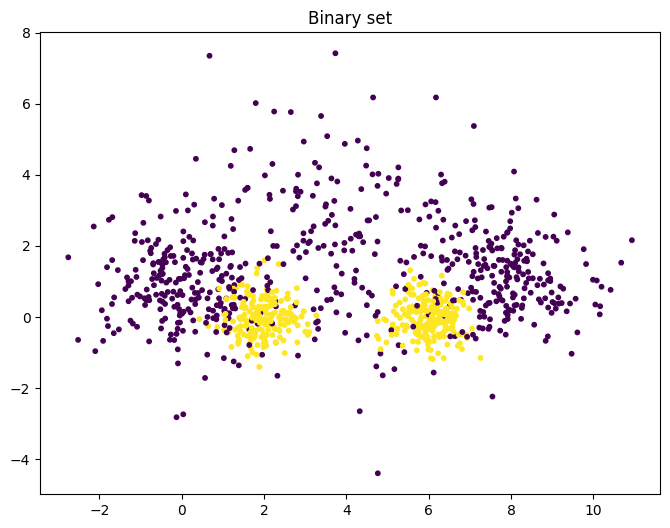

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [8]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [9]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [133]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10, clip=None):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        (N, m) = X_train.shape
        X_train = add_bias(X_train, self.bias)
        
        self.weights = weights = np.zeros(m+1)
        
        for e in range(epochs):
            gradient = X_train.T @ (X_train @ weights - t_train)
            if clip: gradient = np.clip(gradient, -clip, clip)
            weights -= eta / N * gradient
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold
    
    def accuracy(self, X, gold):
        predicted = self.predict(X)
        return np.mean(predicted == gold)

We can train and test a first classifier.

In [134]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
cl.accuracy(X_val, t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [12]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

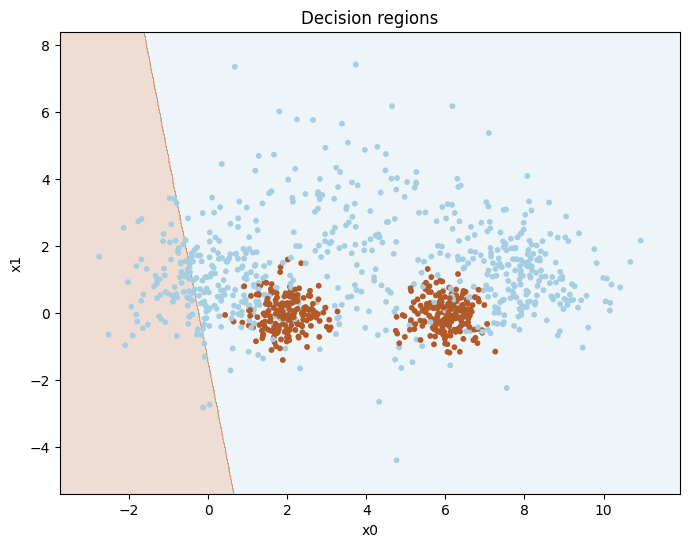

In [13]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried out.

When you are satisfied with the result, you may plot the decision boundaries, as above.

<AxesSubplot: >

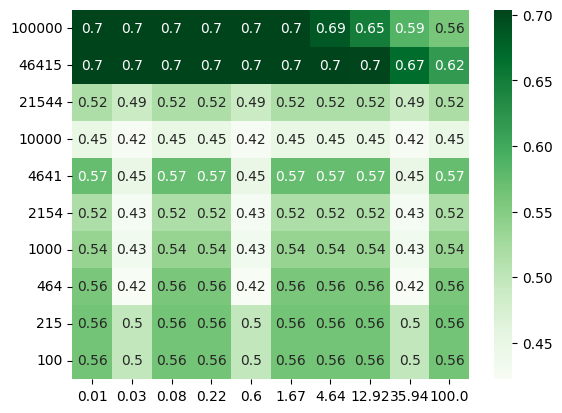

In [14]:
# Generic heatmap
etas = [round(e, 2) for e in np.logspace(-2, 2, num=10)]
epochs = [int(e) for e in np.logspace(5, 2, num=10)]

accuracy_matrix = np.zeros((len(etas), len(epochs)))

for i, eta in enumerate(etas):
    for j, epoch in enumerate(epochs):
        cl = NumpyLinRegClass()
        cl.fit(X_train, t2_train, eta=eta, epochs=epoch, clip=100000)
        accuracy_matrix[i, j] = cl.accuracy(X_val, t2_val)

sns.heatmap(accuracy_matrix, cmap='Greens', annot=True, xticklabels=etas, yticklabels=epochs)

**ANSWER: After introducing clipping to the fit function, we can explore different combinations of etas and epochs. Without clipping we were overflowing during the matrix multiplication.**

**Over the x-axis, we see different step values, and vertically we can see the number of epochs used. A greedy approach will mean taking large steps, but without overshooting, allowing us to reduce the number of epochs. Trying different epoch values between 100 and 1M, we notice major improvements after going above 20k epochs. We also see best results at etas close to 10, Which we can inspect further. Currently, the best accuracy is of 0.7.**

<AxesSubplot: >

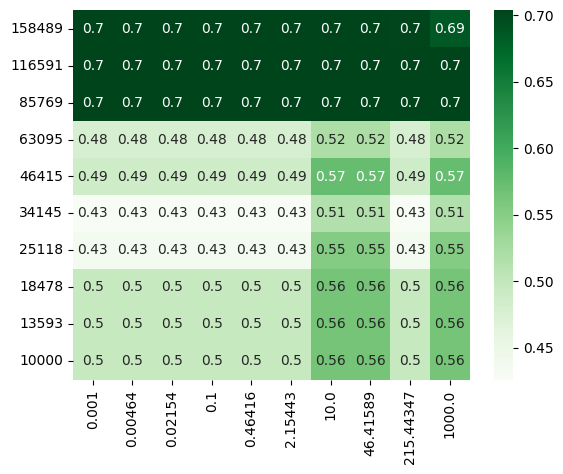

In [15]:
# Heatmap of focused region
etas = [round(e, 5) for e in np.logspace(-3, 3, num=10)]
epochs = [int(e) for e in np.logspace(5.2, 4, num=10)]
clip = 100*1000

accuracy_matrix = np.zeros((len(etas), len(epochs)))

for i, eta in enumerate(etas):
    for j, epoch in enumerate(epochs):
        cl = NumpyLinRegClass()
        cl.fit(X_train, t2_train, eta=eta, epochs=epoch, clip=clip)
        acc = cl.accuracy(X_val, t2_val)
        accuracy_matrix[i, j] = acc

sns.heatmap(accuracy_matrix, cmap='Greens', annot=True, xticklabels=etas, yticklabels=epochs)

**ANSWER: After closer inspection, it seems the best fit values are at 20 eta, and at around 90000 epochs. We can move this into a function, so we don't need to look at the seamap manually:**

In [16]:
def find_best_hyperparams(X_train, t_train, X_val, t_val, eta_range, epochs_range, classifier=NumpyLinRegClass, clip=None):
    best_eta = None
    best_epochs = None
    best_accuracy = 0.0

    for eta in eta_range:
        for epochs in epochs_range:
            cl = classifier()
            cl.fit(X_train, t_train, eta=eta, epochs=epochs, clip=clip)
            val_accuracy = cl.accuracy(X_val, t_val)

            if val_accuracy > best_accuracy:
                best_eta = eta
                best_epochs = epochs
                best_accuracy = val_accuracy

    return best_eta, best_epochs, best_accuracy

best_eta=0.001, best_epochs=158489 at best_accuracy=0.704


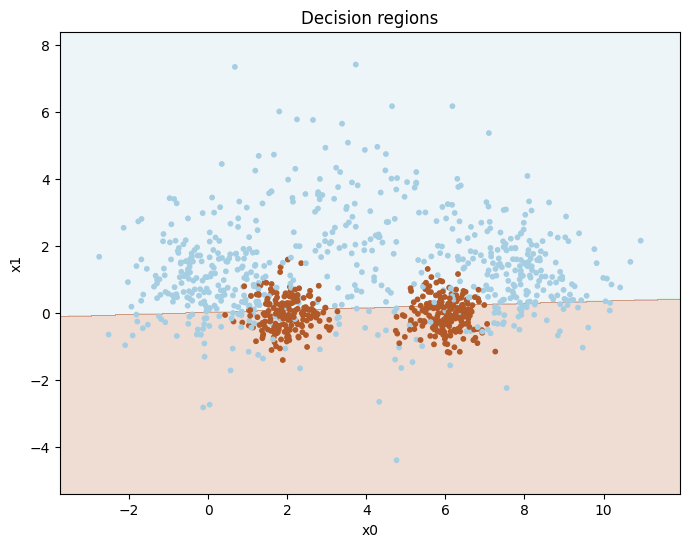

In [17]:
cl = NumpyLinRegClass()

eta_range = (round(e, 5) for e in np.logspace(-3, 3, num=10))
epochs_range = map(int, np.logspace(5.2, 4, num=10))
clip = 1000*1000*1000

best_eta, best_epochs, best_accuracy = find_best_hyperparams(X_train, t2_train, X_val, t2_val, eta_range, epochs_range, clip=clip)
print(f"{best_eta=}, {best_epochs=} at {best_accuracy=}")

cl.fit(X_train, t2_train, eta=best_eta, epochs=best_epochs, clip=clip)
plot_decision_regions(X_train, t2_train, cl)


**ANSWER: Looks pretty good to me :)**

**While the heatmap shows one thing, the results seem more accurate using these lower values. Because of this, I'm going to keep best_eta=0.0298, best_epochs=470 for the next tasks.**

In [129]:
def get_cached_hyperparameters_lin():
    best_eta = 0.0298
    best_epochs = 470
    clip = 1000**3
    return best_eta, best_epochs, clip

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

In [157]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10, clip=None, X_val=None, t_val=None):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        (N, m) = X_train.shape
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            X_val = add_bias(X_val, self.bias) if X_val is not None else X_val
        
        self.weights = weights = np.zeros(m+1)
        self.losses = [0]*epochs
        self.accuracies = [0]*epochs
        self.val_accuracy = [0]*epochs
        
        for e in range(epochs):
            gradient = X_train.T @ (X_train @ weights - t_train)
            if clip: gradient = np.clip(gradient, -clip, clip)
            weights -= eta / N * gradient
            
            # Calculate mean squared error loss on training data
            t_pred = X_train @ weights
            loss = np.mean((t_pred - t_train) ** 2)
            self.losses[e] = loss
            
            # Calculate accuracy on training data
            self.accuracies[e] = self.accuracy(X_train, t_train, need_bias=False)
            
            if X_val is not None and t_val is not None:
                self.val_accuracy[e] = self.accuracy(X_val, t_val, need_bias=False)
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        ys = X @ self.weights
        return ys > threshold
    
    def accuracy(self, X, gold, need_bias=True):
        if need_bias:
            X = add_bias(X, self.bias)
        predicted = self.predict(X)
        return np.mean(predicted == gold)


Final accuracy: 0.751
Final loss: 0.18085948490339826


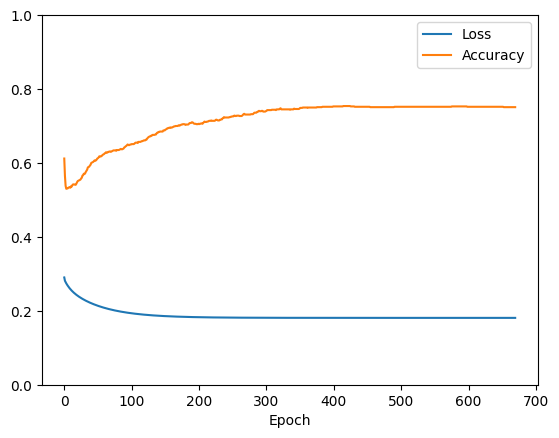

In [158]:
# Visualizing non-scaled accuracy/loss over time
cl = NumpyLinRegClass()
eta, epochs, clip = get_cached_hyperparameters_lin()

epochs += 200  # just for the visualization

cl.fit(X_train, t2_train, eta=eta, epochs=epochs, clip=clip)

print(f"Final accuracy: {cl.accuracies[-1]}")
print(f"Final loss: {cl.losses[-1]}")
plt.plot(cl.losses, label="Loss")
plt.plot(cl.accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylim((0, 1.0))
plt.legend()
plt.show()

**ANSWER: We can see the loss going down at a stable but slow rate over time, which is expected. The accuracy grows at a steady rate after an initial drop during the early epochs, which can probably be explained by the weights being initialized to random values, and noise affecting it quite a bit. Once it gets past the noise, and can work on imporiving the underlying patterns, it starts growing as we expect. Aditionally it seems to flatten out towards the end of our epochs. The functions are monotone, except the early dip.**

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

In [21]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def tune(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean) / self.std

Final accuracy: 0.753
Final loss: 0.18085927539474342


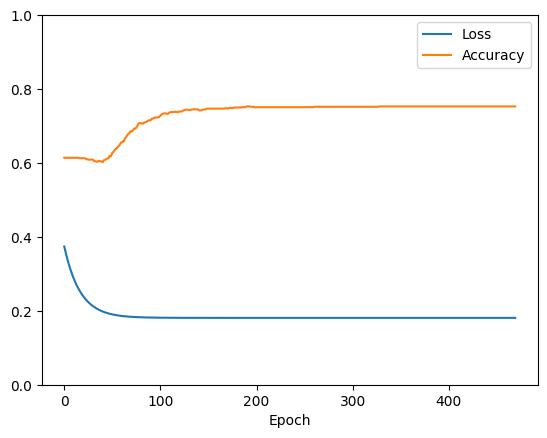

In [22]:
# Visualizing scaled accuracy/loss over time
scaler = StandardScaler()
scaler.tune(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

cl = NumpyLinRegClass()
eta, epochs, clip = get_cached_hyperparameters_lin()

cl.fit(X_train_scaled, t2_train, eta=eta, epochs=epochs, clip=clip)

print(f"Final accuracy: {cl.accuracies[-1]}")
print(f"Final loss: {cl.losses[-1]}")
plt.plot(cl.losses, label="Loss")
plt.plot(cl.accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylim((0, 1.0))
plt.legend()
plt.show()


**ANSWER: After using a scaler, we see a much faster drop in the loss, and the accuracy hits its max value after only 100 epochs. That's much faster! We needed around 400 epochs previously. The drop in accuracy at the beginning is mostly gone now, too.**

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [101]:
class LogisticRegression(NumpyClassifier):
    def fit(self, X_train, t_train, eta = 0.1, epochs=10, X_val=None, t_val=None, tolerance=0.01, patience=10, bias=-1, clip=None):
        # from week 7
        self.bias = bias
        self.accuracies_train = []
        self.losses_train = []
        self.accuracies_val = []
        self.losses_val = []
        (N, m) = X_train.shape
        
        X_train = add_bias(X_train, self.bias)
        X_val = add_bias(X_val, self.bias) if X_val is not None else None
        self.weights = weights = np.zeros(m+1)  # +1 for the bias
        
        ttl = patience

        while ttl >= 0 and epochs > 0:
            weights -= (eta / N) * (X_train.T @ (self.forward(X_train) - t_train))

            loss = self.binary_cross_entropy_loss(X_train, t_train)
            self.losses_train.append(loss)
            
            acc = self.accuracy_biased(X_train, t_train)
            self.accuracies_train.append(acc)
        
            if X_val is not None and t_val is not None:            
                # include accuracy for epoch
                accuracy = self.accuracy_biased(X_val, t_val)
                loss = self.binary_cross_entropy_loss(X_val, t_val)
                
                self.accuracies_val.append(accuracy)
                self.losses_val.append(loss)

            # should we continue
            ttl = patience if tolerance >= abs(loss) else ttl-1
            epochs -= 1
    
    def logistic(self, x):
        x = np.clip(x, -500, 500)  # e^709.8 is approximately float64's limit
        return 1 / (1 + np.exp(-x))

    def forward(self, X):
        return self.logistic(X @ self.weights)
    
    def predict(self, X, threshold=0.5, already_biased=False):
        X = add_bias(X, self.bias) if not already_biased else X
        forward = self.forward(X)
        return (forward > threshold).astype('int')
    
    def predict_probability(self, X_biased):
        return self.forward(X_biased)
    
    def binary_cross_entropy_loss(self, X, t, clip=1e-15):
        predicted = np.clip(self.forward(X), clip, 1-clip)
        return -(t * np.log(predicted) + (1 - t) * np.log(1 - predicted)).mean()
    
    def get_boundaries(self, index1, index2):
        xmin, xmax = X[:, index1].min() - 0.5, X[:, index1].max() + 0.5
        ymin, ymax = X[:, index2].min() - 0.5, X[:, index2].max() + 0.5
        xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.01), np.arange(ymin, ymax, 0.01))
        
    
    def accuracy_biased(self, X_biased, gold):
        predicted = self.predict(X_biased, already_biased=True)
        return np.mean(predicted == gold)
    
    def accuracy(self, X, gold):
        #X = add_bias(X, self.bias)
        predicted = self.predict(X)
        return np.mean(predicted == gold)


    

<AxesSubplot: >

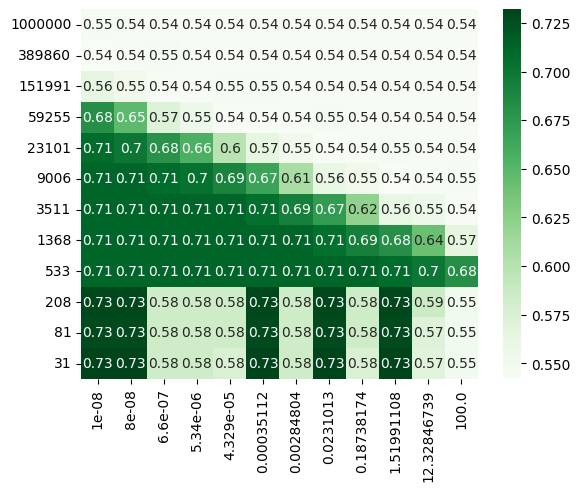

In [24]:
# Getting the heatmap for Logistic Regression

etas = [round(e, 8) for e in np.logspace(-8, 2, num=12)]
epochs = [int(e) for e in np.logspace(6, 1.5, num=12)]

accuracy_matrix = np.zeros((len(etas), len(epochs)))

for i, eta in enumerate(etas):
    for j, epoch in enumerate(epochs):
        cl = LogisticRegression()
        cl.fit(X_train, t2_train, eta=eta, epochs=epoch, tolerance=10, patience=10)
        accuracy_matrix[i, j] = cl.accuracy(X_val, t2_val)

sns.heatmap(accuracy_matrix, cmap='Greens', annot=True, xticklabels=etas, yticklabels=epochs)

**ANSWER: We can see we need much smaller values in the logistic regression than we did in the linear regression, since we're using a different formula this time. It seems like the ideal eta now is around 0.05, and the epochs can stay in the hundreds, instead of the tens of thousands. Running for too long seems to actually reduce our accuracy, likely due to overfitting. Again, we have included clipping to avoid overflows. This clipping shouldn't affect the results much, other than at extreme values of eta and the resulting weights.**

**Again, we want to automatize this. We modify our previous function, including a parameter to specify the classifier**

In [90]:
def find_best_hyperparams(X_train, t_train, X_val, t_val, eta_range, epochs_range, classifier=LogisticRegression, clip=None):
    best_eta = None
    best_epochs = None
    best_accuracy = 0.0

    for eta in eta_range:
        for epochs in epochs_range:
            cl = classifier()
            cl.fit(X_train, t_train, eta=eta, epochs=epochs, clip=clip, tolerance=10, patience=10)
            val_accuracy = cl.accuracy(X_val, t_val)

            if val_accuracy >= best_accuracy:
                best_eta = eta
                best_epochs = epochs
                best_accuracy = val_accuracy

    return best_eta, best_epochs, best_accuracy

best_eta=0.65793, best_epochs=10000 at best_accuracy=0.746


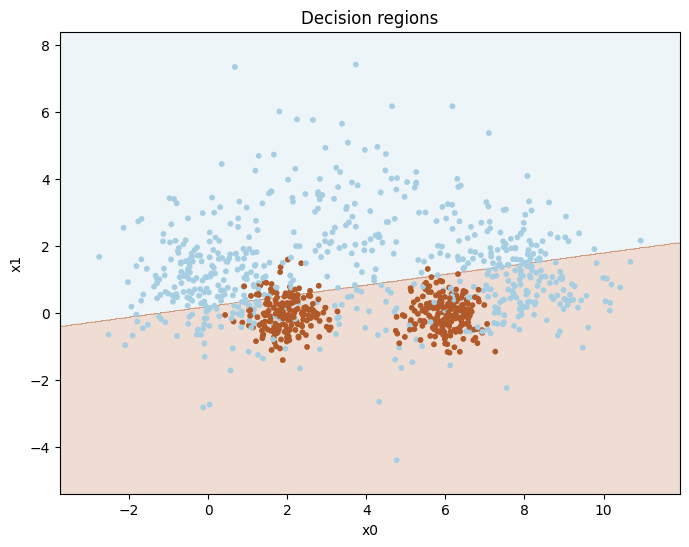

In [ ]:
# Automatic logistic hyperparameters
cl = LogisticRegression()

eta_range = [round(e, 5) for e in np.logspace(-6, 2, num=12)]
epochs_range = [int(e) for e in np.logspace(4, 4, num=12)]

best_eta, best_epochs, best_accuracy = find_best_hyperparams(X_train, t2_train, X_val, t2_val, eta_range, epochs_range, classifier=type(cl))
print(f"{best_eta=}, {best_epochs=} at {best_accuracy=}")

cl.fit(X_train, t2_train, eta=best_eta, epochs=best_epochs, tolerance=50, patience=50) 
plot_decision_regions(X_train, t2_train, cl)

**Again, I'm caching the values to avoid recalculating them later. Using the find_best_hyperparams function directly results in overfit data, so I'm caching the values I observe on the heatmap instead.**

In [107]:
def get_cached_hyperparameters_log():
    best_eta = 0.05
    best_epochs = 800
    clip = 1000**3
    return best_eta, best_epochs, clip

Final accuracy: 0.76
Final loss: 0.49950869420327565


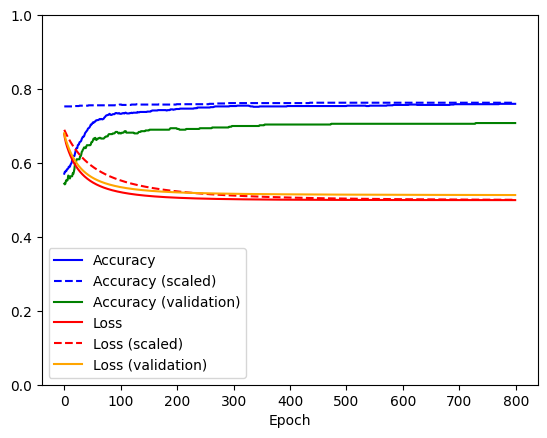

In [108]:
# Visualizing accuracy/loss of normal, scaled and validation set of Logistic Regression
scaler = StandardScaler()
scaler.tune(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

cl = LogisticRegression()
cl_scaled = LogisticRegression()
eta, epochs, clip = get_cached_hyperparameters_log()

cl.fit(X_train, t2_train, X_val=X_val, t_val=t2_val, eta=eta, epochs=epochs, clip=clip, tolerance=10, patience=10)
cl_scaled.fit(X_train_scaled, t2_train, X_val=X_val_scaled, t_val=t2_val, eta=eta, epochs=epochs, clip=clip, tolerance=10, patience=10)


print(f"Final accuracy: {cl.accuracies_train[-1]}")
print(f"Final loss: {cl.losses_train[-1]}")
plt.plot(cl.accuracies_train, label="Accuracy", color="blue")
plt.plot(cl_scaled.accuracies_train, label="Accuracy (scaled)", linestyle="--", color="blue")
plt.plot(cl.accuracies_val, label="Accuracy (validation)", color="green")

plt.plot(cl.losses_train, label="Loss", color="red")
plt.plot(cl_scaled.losses_train, label="Loss (scaled)", linestyle="--", color="red")
plt.plot(cl.losses_val, label="Loss (validation)", color="orange")

plt.xlabel("Epoch")
plt.ylim((0, 1.0))
plt.legend()
plt.show()


**ANSWER: We see that scaling the model to the dataset does not have a major impact here, except at the very early epochs, where it's likely due to chance anyway. We actually gain a worse performance on the loss by scaling it. What we do observe, though, is that we get to an acceptable accuracy after only 100 epochs. This is incredible!**

**As expected, the validation accuracy performs slightly worse than the training accuracy. This occurs since our training has never seen this data, and can't adjust for it. It doesn't look like we're overfitting, either.**

**I don't quite know why the logistic regression works so much better for our particular dataset, but using this approach instead is much faster than using a linear regression due to the reduced epochs required.**

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [168]:
class OneVsRestLogRegression(NumpyClassifier):
    def __init__(self, n_classifiers, eta=0.1, epochs=10, tolerance=0.01, patience=10, bias=-1, clip=None):
        self.classifiers = [LogisticRegression() for _ in range(n_classifiers)]
        self.tolerance = tolerance
        self.patience = patience
        self.eta = eta
        self.epochs = epochs
        self.bias = bias
    
    def fit(self, X_train, t_train, eta=0.1, epochs=10, X_val=None, t_val=None, clip=None):
        self.train_loss = []
        self.val_loss = []
        self.accuracies = [0]*len(self.classifiers)
        
        for i, cl in enumerate(self.classifiers):
            t_train_class = (t_train == i).astype(int)
            cl.fit(X_train, t_train_class, eta=self.eta, epochs=self.epochs, tolerance=self.tolerance, patience=self.patience)
            if X_val is not None and t_val is not None:
                self.accuracies[i] = cl.accuracy(X_val, t_val)
    
    def predict(self, X):
        probs = np.zeros((X.shape[0], len(self.classifiers)))

        X = add_bias(X, self.bias)
        for i, cl in enumerate(self.classifiers):
            probs[:, i] = cl.predict_probability(X)
        
        return np.argmax(probs, axis=1)
    
    def get_boundaries(self, i):
        return self.classifiers[i].get_boundaries(i, i+1)
    
    def accuracy(self, X, t):
        return np.mean([clf.accuracy(X, t) for clf in self.classifiers])


In [ ]:
# Getting the heatmap for 1vR Regression

etas = [round(e, 8) for e in np.logspace(-5, 3, num=12)]
epochs = [int(e) for e in np.logspace(5, 1.5, num=12)]

accuracy_matrix = np.zeros((len(etas), len(epochs)))

for i, eta in enumerate(etas):
    for j, epoch in enumerate(epochs):
        cl = OneVsRestLogRegression(n_classifiers=5, eta=eta, epochs=epoch, tolerance=100, patience=10)
        cl.fit(X_train, t_multi_train, X_val=X_val, t_val=t_multi_val)
        accuracy_matrix[i, j] = cl.accuracy(X_val, t_multi_val)

sns.heatmap(accuracy_matrix, cmap='Greens', annot=True, xticklabels=etas, yticklabels=epochs)

In [131]:
def find_best_hyperparams_multi(X_train, t_train, X_val, t_val, eta_range, epochs_range, classifier=OneVsRestLogRegression, clip=None):
    best_eta = None
    best_epochs = None
    best_accuracy = 0.0

    for eta in eta_range:
        for epochs in epochs_range:
            cl = classifier(n_classifiers=5, eta=eta, epochs=epochs, tolerance=10, patience=10)
            cl.fit(X_train, t_train, eta=eta, epochs=epochs, clip=clip,)
            val_accuracy = cl.accuracy(X_val, t_val)

            if val_accuracy >= best_accuracy:
                best_eta = eta
                best_epochs = epochs
                best_accuracy = val_accuracy

    return best_eta, best_epochs, best_accuracy

# Automatic 1-vs-Rest hyperparameters
cl = OneVsRestLogRegression(n_classifiers=5)

eta_range = [round(e, 5) for e in np.logspace(-6, 2, num=12)]
epochs_range = [int(e) for e in np.logspace(4, 4, num=12)]

best_eta, best_epochs, best_accuracy = find_best_hyperparams_multi(X_train, t_multi_train, X_val, t_multi_val, eta_range, epochs_range, classifier=type(cl))
print(f"{best_eta=}, {best_epochs=} at {best_accuracy=}")

cl.fit(X_train, t2_train, eta=best_eta, epochs=best_epochs, tolerance=50, patience=50) 
plot_decision_regions(X_train, t2_train, cl)

KeyboardInterrupt: 

In [112]:
def get_cached_hyperparameters_1vR():
    eta = 0.01
    epochs = 100*1000
    clip = 100
    return eta, epochs, clip
    

Accuracy on validation data: 0.1728


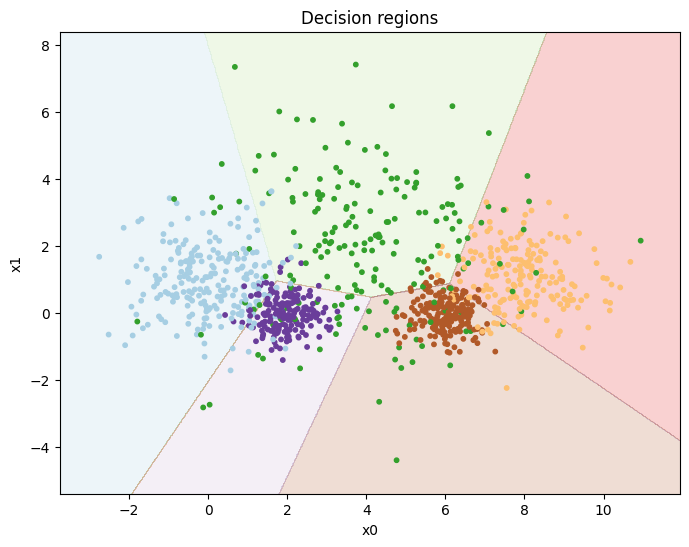

In [124]:
eta, epochs, clip = get_cached_hyperparameters_1vR()

ovr_cl = OneVsRestLogRegression(n_classifiers=5, eta=eta, epochs=epochs, tolerance=100, patience=10)
ovr_cl.fit(X_train, t_multi_train, X_val=X_val, t_val=t_multi_val)

# Evaluate the accuracy of the classifier on the validation data
accuracy = ovr_cl.accuracy(X_val, t_multi_val)
print(f"Accuracy on validation data: {accuracy:.4f}")

plot_decision_regions(X_train, t_multi_train, ovr_cl)

**ANSWER: The results look okay, but there seems to be an issue with how I'm representing the accuracy after training, since 0.17 is far from the correct accuracy here.**

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [ ]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
                return 1/(1+np.exp(-x))
        self.activ = logistic

        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, eta=0.001, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

In [ ]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, eta=0.001, epochs=100, patience=10, tolerance=0.005,
            X_val=None, t_val=None):
        """Intialize the weights. Train *epochs* many epochs.

        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data,
        where the values are 0 or 1.

        X_val is a matrix containing the validation input data
        t_val is a vector of targets for the validation data
        """
        self.eta = eta

        T_train = t_train.reshape(-1, 1)

        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]

        # Initialize the weights
        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden + 1, dim_out) * 2 - 1) / np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)

        # Store the loss and accuracy after each epoch for training and validation data
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        ttl = patience
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the hidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))

            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas

            # Calculate the loss and accuracy for the epoch
            train_loss = self.binary_cross_entropy_loss(X_train_bias, t_train)
            train_accuracy = self.accuracy(X_train, t_train)

            if X_val is not None and t_val is not None:
                val_loss = self.binary_cross_entropy_loss(X_val, t_val)
                val_accuracy = self.accuracy(X_val, t_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_accuracy)

            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_accuracy)

            if train_accuracy < tolerance:
                ttl -= 1
            else:
                ttl = patience

            if ttl <= 0:
                break

    def accuracy(self, X, gold):
        X = add_bias(X, self.bias)
        predicted = self.predict(X)
        return np.mean(predicted == gold)

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)
    
    def predict_probability(self, X):
        """Predict the probability of the positive class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        return forw[:, 0]
    
    def binary_cross_entropy_loss(self, X, t, clip=1e-15):
        predicted = np.clip(self.predict_probability(X), clip, 1-clip)
        return -(t * np.log(predicted) + (1 - t) * np.log(1 - predicted)).mean()


In [ ]:
import matplotlib.pyplot as plt

cl = MLPBinaryLinRegClass()

# Train the model with validation set
cl.fit(X_train, t_multi_train, X_val=X_val, t_val=t_multi_val, epochs=100)

# Plot the loss and accuracy for both training and validation sets
plt.plot(model.losses, label='Training Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.plot(model.accuracies, label='Training Accuracy')
plt.plot(model.val_accuracies, label='Validation Accuracy')
plt.legend()
plt.show()

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

In [169]:

cl_lin = NumpyLinRegClass()
cl_log = LogisticRegression()
cl_1vR = OneVsRestLogRegression(n_classifiers=5)

cl_lin_eta, cl_lin_epochs, cl_lin_clip = get_cached_hyperparameters_lin()
cl_lin.fit(X_train, t2_train, eta=cl_lin_eta, epochs=cl_lin_epochs, X_val=X_val, t_val=t2_val)
cl_lin_acc_train = cl_lin.accuracy(X_train, t2_train)
cl_lin_acc_validation = cl_lin.accuracy(X_val, t2_val)
cl_lin_acc_test = cl_lin.accuracy(X_test, t2_test)
cl_lin_accuracies = cl_lin_acc_train, cl_lin_acc_validation, cl_lin_acc_test

cl_log_eta, cl_log_epochs, cl_log_clip = get_cached_hyperparameters_log()
cl_log.fit(X_train, t2_train, eta=cl_log_eta, epochs=cl_log_epochs, X_val=X_val, t_val=t2_val)
cl_log_acc_train = cl_log.accuracy(X_train, t2_train)
cl_log_acc_validation = cl_log.accuracy(X_val, t2_val)
cl_log_acc_test = cl_log.accuracy(X_test, t2_test)
cl_log_accuracies = cl_log_acc_train, cl_log_acc_validation, cl_log_acc_test

cl_1vR_eta, cl_1vR_epochs, cl_1vR_clip = get_cached_hyperparameters_1vR()
cl_1vR.fit(X_train, t2_train, eta=cl_1vR_eta, epochs=cl_1vR_epochs, X_val=X_val, t_val=t2_val)
cl_1vR_acc_train = cl_1vR.accuracy(X_train, t2_train)
cl_1vR_acc_validation = cl_1vR.accuracy(X_val, t2_val)
cl_1vR_acc_test = cl_1vR.accuracy(X_test, t2_test)
cl_1vR_accuracies = cl_1vR_acc_train, cl_1vR_acc_validation, cl_1vR_acc_test

cells = "{:>20} {:>15} {:>15} {:>15}"
print(cells.format("Model", "Training", "Validation", "Testing"))
print(cells.format("Linear", *cl_lin_accuracies))
print(cells.format("Logistic", *cl_log_accuracies))
print(cells.format("1-vs-Rest", *cl_1vR_accuracies))


               Model        Training      Validation         Testing
              Linear           0.751           0.704           0.724
            Logistic            0.59           0.558           0.582
           1-vs-Rest          0.5414          0.5264          0.5348


**ANSWER: While likely due to the underperforming analysis of hyperparameters for the 1-vs-rest, and the bug in the accuracy, we see a low ~53% accuracy for the 1-vs-Rest for all the datasets. I suspect my accuracy formula is wrong. The best performance is always on the training set, which makes sense, but we are not overfitting for it. The validation and testings sets perform similarly. I am actually surprised the testing set performs slightly better than the validation set... even if we never train on the validation set.**

**Overall, the linear set performs the best of all three classifiers, but, again, I believe this is due to a good analysis of hyperparameters.**